In [149]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th


In [150]:
from engiopt.cgan_vae.cgan_vae import Encoder
from engiopt.cgan_vae.cgan_vae import Generator3D
from engiopt.cgan_cnn_3d.cgan_cnn_3d import Generator3D as Generator3DCNN
from engiopt.metrics import dpp_diversity

In [151]:
from datasets import load_dataset

# Example: Load the heat conduction 3D dataset (replace with your actual dataset name)
dataset = load_dataset("IDEALLab/heat_conduction_3d_v0", split="train", cache_dir="/cluster/scratch/chatterer/SemesterProject/datasets")
print(dataset)



Dataset({
    features: ['volume', 'area', 'optimal_design'],
    num_rows: 361
})


In [152]:
# Access an example
example = dataset[0]

print("Dataset features:", dataset.features)
print("Number of rows:", len(dataset))
print("First example keys:", example.keys())
print("Volume:", example["volume"])
print("Area:", example["area"])
print("Optimal design shape:", np.array(example["optimal_design"]).shape)

Dataset features: {'volume': Value(dtype='float64', id=None), 'area': Value(dtype='float64', id=None), 'optimal_design': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None)}
Number of rows: 361
First example keys: dict_keys(['volume', 'area', 'optimal_design'])
Volume: 0.3
Area: 0.0
Optimal design shape: (51, 51, 51)


In [153]:
slices = example["optimal_design"]  # Replace "slices" with the actual key in your dataset
slices_tensor = th.tensor(slices, dtype=th.float32)

In [154]:
# Load trained models - using the VAE-based generator
encoder = Encoder(latent_dim=64)
generator = Generator3D(latent_dim=64, n_conds=2, design_shape=(64, 64, 64))

device = th.device("cuda" if th.cuda.is_available() else "cpu")
map_location = device if th.cuda.is_available() else th.device("cpu")

state_dict = th.load("/cluster/scratch/chatterer/SemesterProject/multiview_3d_vaegan.pth", map_location=map_location)
encoder.load_state_dict(state_dict["encoder"])
generator.load_state_dict(state_dict["generator"])
encoder.eval()
generator.eval()

encoder.to(device)
generator.to(device)
slices_tensor = slices_tensor.to(device)


In [155]:
# Load trained models - using the CNN-based generator
generatorcnn = Generator3DCNN(latent_dim=64, n_conds=2, design_shape=(64, 64, 64))

state_dict = th.load("/cluster/scratch/chatterer/SemesterProject/generator_3d.pth", map_location=map_location)
generatorcnn.load_state_dict(state_dict["generator"])
encoder.eval()
generatorcnn.eval()

generatorcnn.to(device)

Generator3D(
  (z_path): Sequential(
    (0): ConvTranspose3d(64, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (c_path): Sequential(
    (0): ConvTranspose3d(2, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up_blocks): Sequential(
    (0): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose3d(128, 64, kernel_size

In [156]:
def reparameterize(mu: th.Tensor, logvar: th.Tensor) -> th.Tensor:
    """Reparameterization trick for VAE with numerical stability."""
    # Clamp logvar to prevent extreme values
    logvar = th.clamp(logvar, min=-20, max=20)
    std = th.exp(0.5 * logvar)
    eps = th.randn_like(std)
    return mu + eps * std


In [157]:

# --- Extract a subset of XY slices from each volume ---
designs_3d = slices_tensor.unsqueeze(0).unsqueeze(1)  # (1, 1, D, H, W)
D, H, W = designs_3d.shape[2], designs_3d.shape[3], designs_3d.shape[4]
n_slices = min(8, D)  # You can set n_slices as desired (replace 16 with args.n_slices if available)
slice_indices = th.linspace(0, D - 1, n_slices).long()
slices = designs_3d[:, :, slice_indices, :, :]  # (1, 1, n_slices, H, W)
slices = slices.permute(0, 2, 1, 3, 4)  # (1, n_slices, 1, H, W)
slices = slices.reshape(-1, 1, H, W)  # (n_slices, 1, H, W)
# Encode slices to latent vector
with th.no_grad():
    mu, logvar = encoder(slices)
    mu = mu.mean(dim=0, keepdim=True)  # Mean pool over slices
    z_encoded = reparameterize(mu,logvar)  # Or use reparameterize(mu, logvar)

In [158]:
# Choose a condition (example: [0.5, 0.5])
cond = th.tensor([[0.5, 0.5]], dtype=th.float32).to(device)
cond = cond.view(1, 2, 1, 1, 1)

In [159]:
# Pool the latent vectors over slices to get a single latent vector
z_encoded_pooled = z_encoded.mean(dim=0, keepdim=True)  # shape: [1, 64]

# Generate 3D design from encoded slices
gen_from_slices = generator(z_encoded_pooled.view(1, 64, 1, 1, 1), cond)
gen_from_slices_np = gen_from_slices.squeeze(0).cpu().detach().numpy()

# Generate 3D design from random noise
z_random = th.randn_like(z_encoded_pooled)  # shape [1, 64]
gen_from_noise = generator(z_random.view(1, 64, 1, 1, 1), cond)
gen_from_noise_np = gen_from_noise.squeeze(0).cpu().detach().numpy()


In [160]:
# Generate from random noise with CNN generator
z_random_cnn = th.randn(1, 64, 1, 1, 1).to(device)  # Random noise
gen_from_cnn_noise = generatorcnn(z_random_cnn, cond)
gen_from_cnn_noise_np = gen_from_cnn_noise.squeeze(0).cpu().detach().numpy()

print("CNN Generator shapes:")
print(f"Generated from noise: {gen_from_cnn_noise_np.shape}")

CNN Generator shapes:
Generated from noise: (1, 64, 64, 64)


In [161]:
# Load multiple examples from dataset
n_examples = 50
examples = [dataset[i] for i in range(min(n_examples, len(dataset)))]
multiple_designs = [th.tensor(ex["optimal_design"], dtype=th.float32) for ex in examples]

# Stack and reshape
designs_array = th.stack(multiple_designs, dim=0).numpy()
designs_for_dpp = designs_array.reshape(designs_array.shape[0], -1)

# Compute DPP diversity
dpp_value = dpp_diversity(designs_for_dpp, sigma=10)
print(f"DPP diversity for {n_examples} dataset designs: {dpp_value}")

DPP diversity for 50 dataset designs: 3.952519724179664e-12


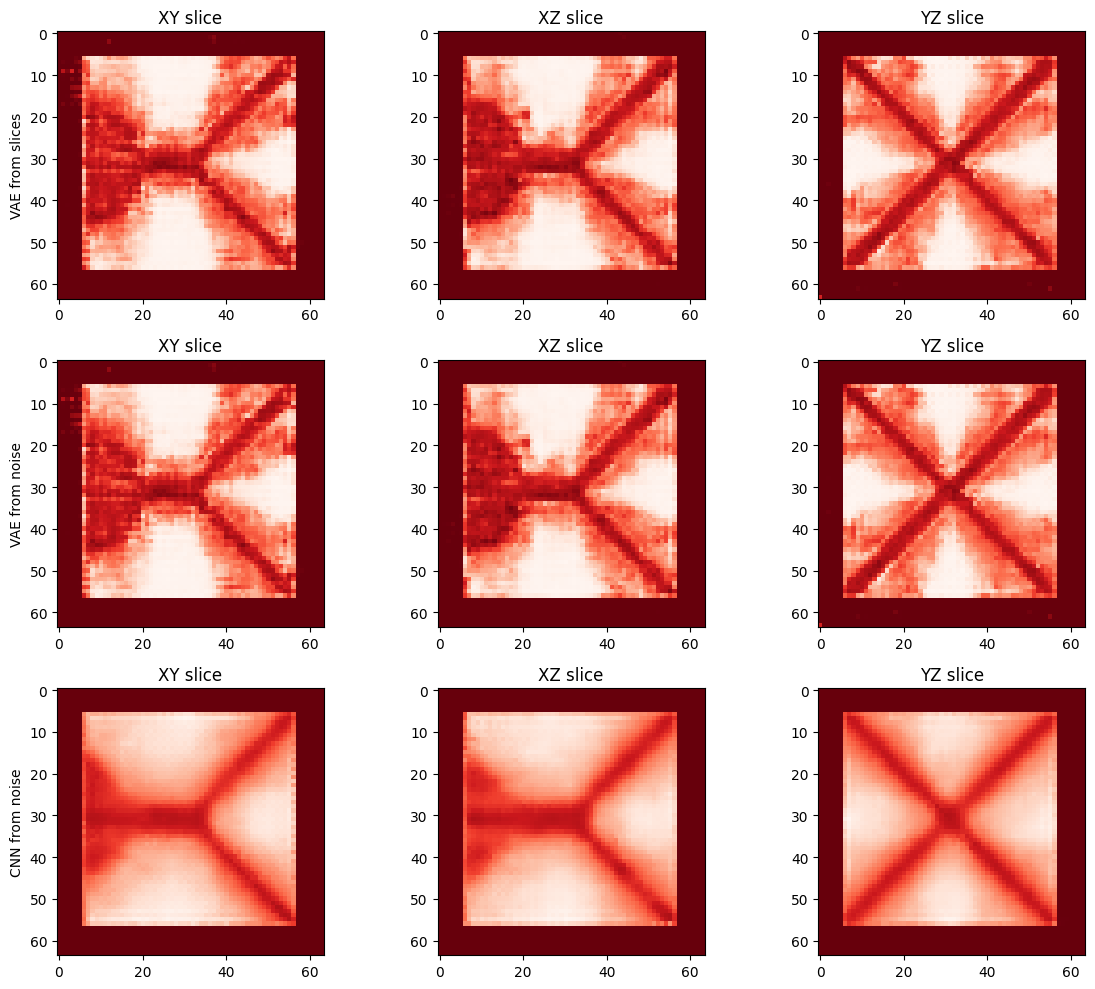

In [163]:
# Plot central slices for comparison - All generators
fig, axes = plt.subplots(3,3, figsize=(12, 10))
volumes_and_labels = [
    (gen_from_slices_np, "VAE from slices"),
    (gen_from_noise_np, "VAE from noise"),
    (gen_from_cnn_noise_np, "CNN from noise")
]

for i, (vol, label) in enumerate(volumes_and_labels):
    vol = np.squeeze(vol)  # Remove leading singleton dimension if present
    d, h, w = vol.shape
    axes[i, 0].imshow(vol[d // 2, :, :], cmap="Reds_r")
    axes[i, 0].set_title("XY slice")
    axes[i, 1].imshow(vol[:, h // 2, :], cmap="Reds_r")
    axes[i, 1].set_title("XZ slice")
    axes[i, 2].imshow(vol[:, :, w // 2], cmap="Reds_r")
    axes[i, 2].set_title("YZ slice")
    axes[i, 0].set_ylabel(label)

plt.tight_layout()
plt.show()

/tmp/ipykernel_4080184/472791048.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


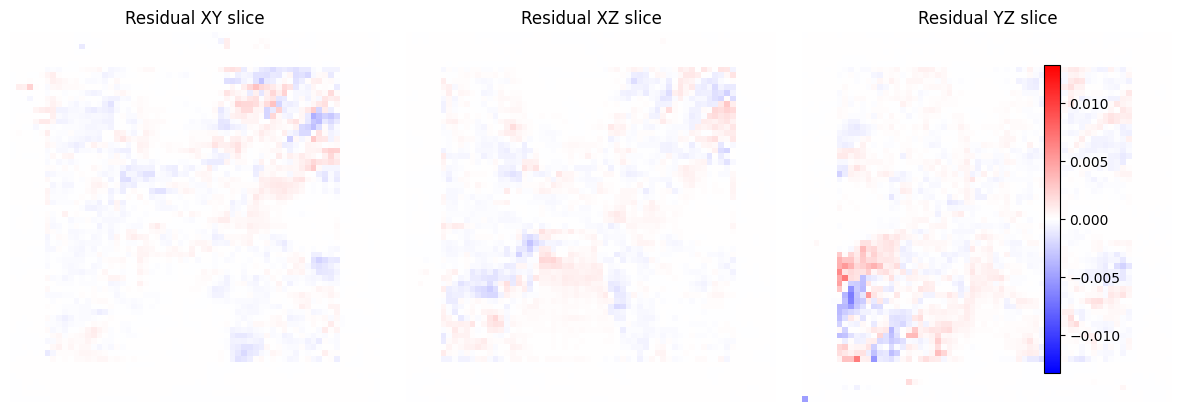

In [164]:
# Remove leading singleton dimension if present
residuals_vol = np.squeeze(gen_from_slices_np - gen_from_noise_np)

# Plot central slices for comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# If residuals_vol has shape (D, H, W), get central indices:
central_indices = [s // 2 for s in residuals_vol.shape]

axes[0].imshow(residuals_vol[central_indices[0], :, :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[0].set_title("Residual XY slice")
axes[1].imshow(residuals_vol[:, central_indices[1], :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[1].set_title("Residual XZ slice")
axes[2].imshow(residuals_vol[:, :, central_indices[2]], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[2].set_title("Residual YZ slice")
im = axes[0].imshow(residuals_vol[central_indices[0], :, :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.025, pad=0.04)
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()
# Add colorbar to the residual plots

In [165]:
# Statistical analysis of residuals
mean_residual = np.mean(residuals_vol)
std_residual = np.std(residuals_vol)
min_residual = np.min(residuals_vol)
max_residual = np.max(residuals_vol)
median_residual = np.median(residuals_vol)
percentile_25 = np.percentile(residuals_vol, 25)
percentile_75 = np.percentile(residuals_vol, 75)

print("Residuals Statistical Analysis:")
print(f"Mean: {mean_residual:.4f}")
print(f"Std Dev: {std_residual:.4f}")
print(f"Min: {min_residual:.4f}")
print(f"Max: {max_residual:.4f}")
print(f"Median: {median_residual:.4f}")
print(f"25th Percentile: {percentile_25:.4f}")
print(f"75th Percentile: {percentile_75:.4f}")

Residuals Statistical Analysis:
Mean: 0.0000
Std Dev: 0.0005
Min: -0.0122
Max: 0.0133
Median: 0.0000
25th Percentile: -0.0000
75th Percentile: 0.0000


In [166]:
# Comprehensive Residual Analysis - All Generators (VAE + CNN)
# Crop generated volumes to match original slice size (center crop from 64x64x64 to 51x51x51)
def center_crop_3d(arr, target_shape):
    start = [(s - t) // 2 for s, t in zip(arr.shape, target_shape)]
    end = [start[i] + target_shape[i] for i in range(3)]
    return arr[start[0]:end[0], start[1]:end[1], start[2]:end[2]]

# Crop all generated volumes to match original size
gen_cropped_from_slices = center_crop_3d(gen_from_slices_np.squeeze(), (51, 51, 51))
gen_cropped_from_noise = center_crop_3d(gen_from_noise_np.squeeze(), (51, 51, 51))
gen_cropped_from_cnn_noise = center_crop_3d(gen_from_cnn_noise_np.squeeze(), (51, 51, 51))
orig_vol = slices_tensor.cpu().numpy()

# Calculate residuals for VAE-based generator
residuals_1_vae_noise_vs_original = gen_cropped_from_noise - orig_vol
residuals_2_vae_slices_vs_original = gen_cropped_from_slices - orig_vol
residuals_3_vae_noise_vs_slices = gen_cropped_from_noise - gen_cropped_from_slices

# Calculate residuals for CNN-based generator
residuals_4_cnn_vs_original = gen_cropped_from_cnn_noise - orig_vol
residuals_5_cnn_noise_vs_original = gen_cropped_from_cnn_noise - orig_vol

# Cross-model comparisons
residuals_6_vae_noise_vs_cnn_noise = gen_cropped_from_noise - gen_cropped_from_cnn_noise

print("Extended Residual Analysis Summary:")
print("=== VAE-based Generator ===")
print("1. VAE Noise vs Original: Random generation quality")
print("2. VAE Slices vs Original: Reconstruction quality") 
print("3. VAE Noise vs VAE Slices: Encoding information preservation")
print("\n=== CNN-based Generator ===")
print("4. CNN vs Original: CNN reconstruction from original input")
print("5. CNN Noise vs Original: CNN random generation quality")
print("6. CNN vs CNN Noise: CNN consistency between input types")
print("\n=== Cross-Model Comparisons ===")
print("7. VAE Noise vs CNN Noise: Random generation method comparison")

Extended Residual Analysis Summary:
=== VAE-based Generator ===
1. VAE Noise vs Original: Random generation quality
2. VAE Slices vs Original: Reconstruction quality
3. VAE Noise vs VAE Slices: Encoding information preservation

=== CNN-based Generator ===
4. CNN vs Original: CNN reconstruction from original input
5. CNN Noise vs Original: CNN random generation quality
6. CNN vs CNN Noise: CNN consistency between input types

=== Cross-Model Comparisons ===
7. VAE Noise vs CNN Noise: Random generation method comparison


/tmp/ipykernel_4080184/2194704012.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


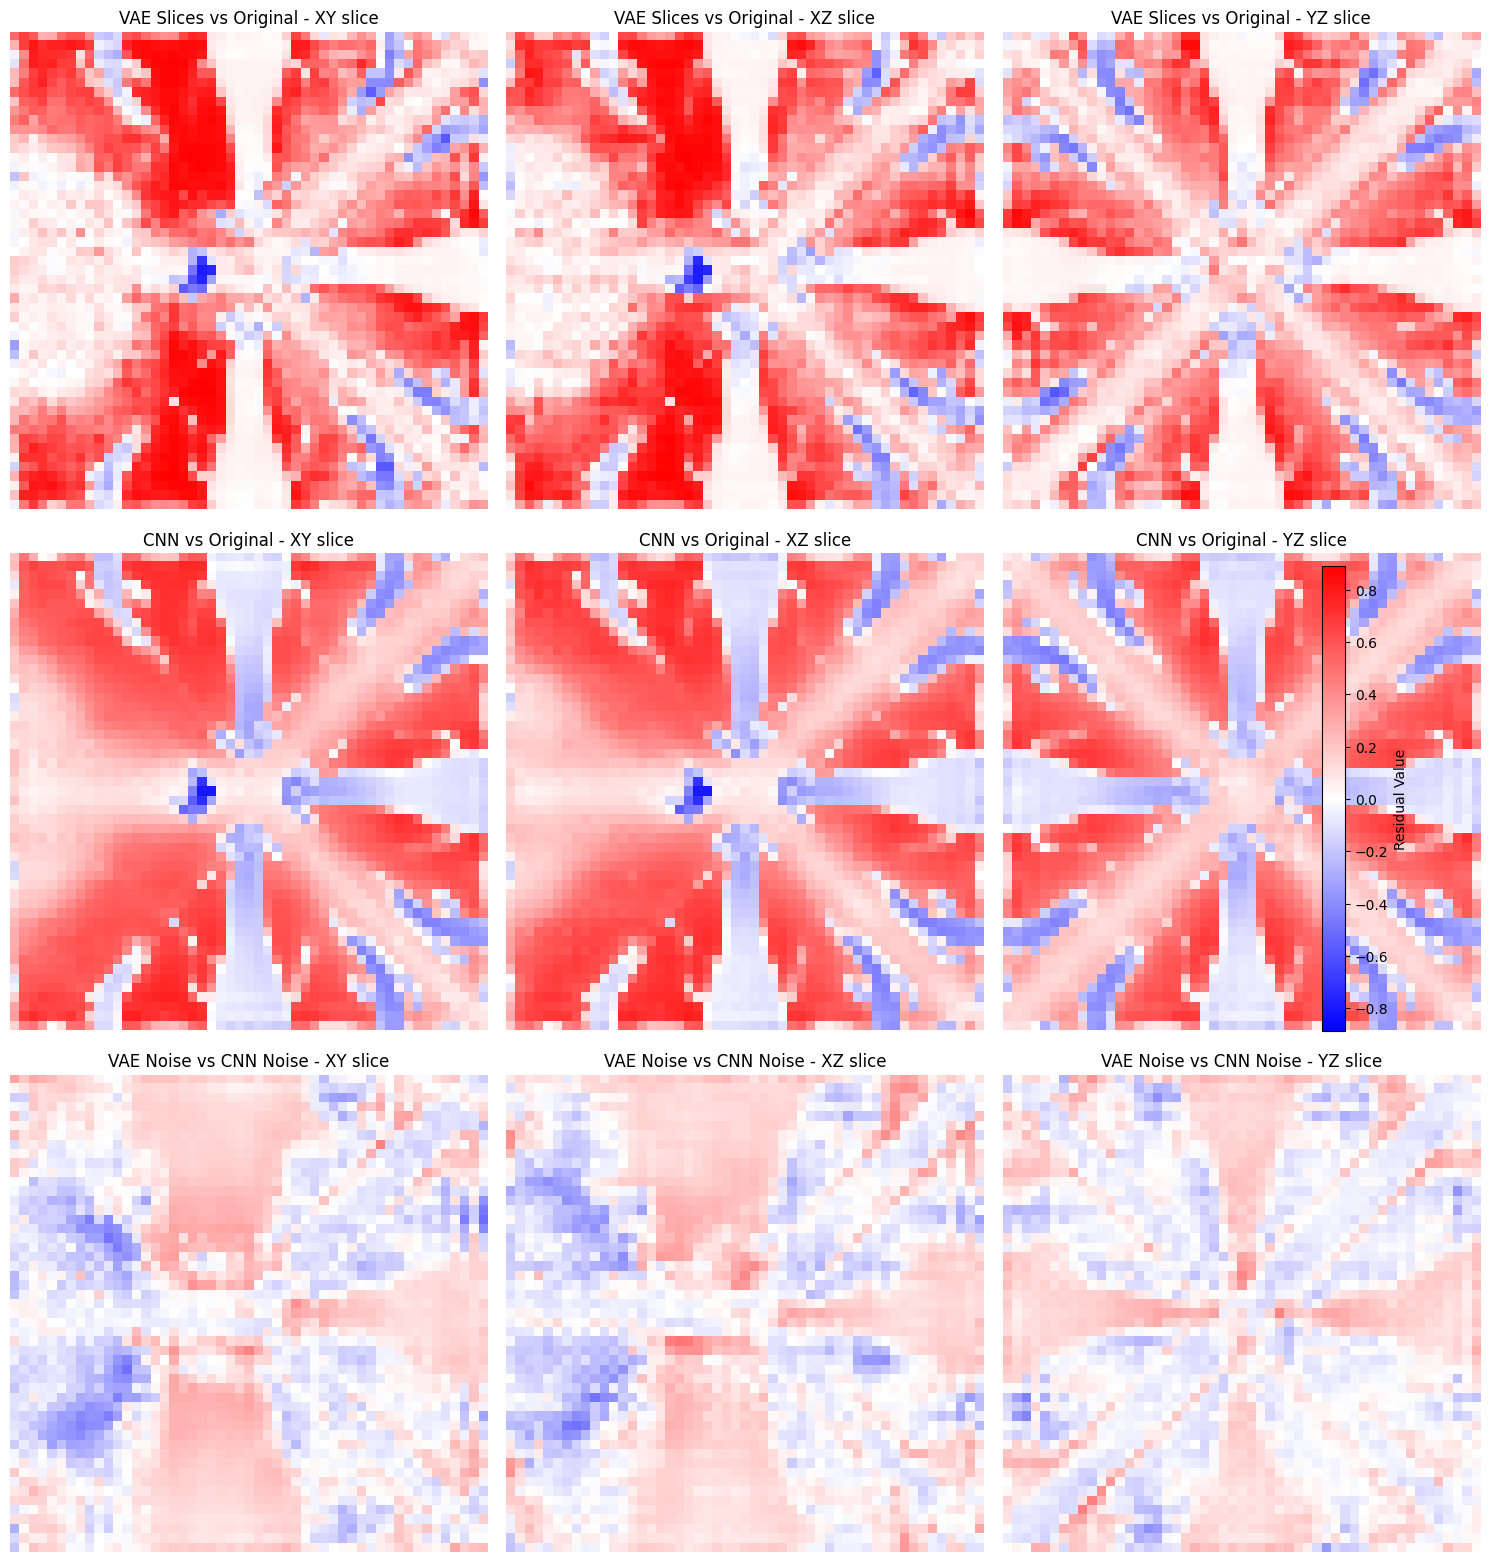

In [167]:
# Comprehensive Residual Visualization - VAE vs CNN Generators
fig, axes = plt.subplots(3, 3, figsize=(15, 16))

# Select key residuals for visualization
residuals_list = [
    residuals_2_vae_slices_vs_original,  # VAE reconstruction
    residuals_4_cnn_vs_original,         # CNN reconstruction
    residuals_6_vae_noise_vs_cnn_noise   # VAE vs CNN random generation
]

titles = [
    "VAE Slices vs Original", 
    "CNN vs Original", 
    "VAE Noise vs CNN Noise"
]

descriptions = [
    "VAE reconstruction quality",
    "CNN reconstruction quality", 
    "Random generation comparison"
]

for row, (residuals, title, desc) in enumerate(zip(residuals_list, titles, descriptions)):
    # Get the maximum absolute value for consistent colorbar scaling
    vmax = np.max(np.abs(residuals))
    
    # XY slice (central)
    axes[row, 0].imshow(residuals[25, :, :], cmap="bwr", vmin=-vmax, vmax=vmax)
    axes[row, 0].set_title(f"{title} - XY slice")
    axes[row, 0].axis("off")
    
    # XZ slice (central)
    axes[row, 1].imshow(residuals[:, 25, :], cmap="bwr", vmin=-vmax, vmax=vmax)
    axes[row, 1].set_title(f"{title} - XZ slice")
    axes[row, 1].axis("off")
    
    # YZ slice (central)
    im = axes[row, 2].imshow(residuals[:, :, 25], cmap="bwr", vmin=-vmax, vmax=vmax)
    axes[row, 2].set_title(f"{title} - YZ slice")
    axes[row, 2].axis("off")
    
    # Add description as ylabel
    axes[row, 0].set_ylabel(f"{desc}\n({title})", fontsize=9, rotation=90, labelpad=60)

# Add a single colorbar for the entire figure
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04, label="Residual Value")

plt.tight_layout()
plt.show()

In [168]:
# Comprehensive Statistical Analysis for VAE and CNN Generators
def analyze_residuals(residuals, name):
    """Compute comprehensive statistics for residuals"""
    stats = {
        'mean': np.mean(residuals),
        'std': np.std(residuals),
        'min': np.min(residuals),
        'max': np.max(residuals),
        'median': np.median(residuals),
        'p25': np.percentile(residuals, 25),
        'p75': np.percentile(residuals, 75),
        'mse': np.mean(residuals**2),
        'mae': np.mean(np.abs(residuals)),
        'rmse': np.sqrt(np.mean(residuals**2))
    }
    return stats

# Analyze all residual types
residuals_data = [
    # VAE Generator
    (residuals_1_vae_noise_vs_original, "1. VAE Noise vs Original"),
    (residuals_2_vae_slices_vs_original, "2. VAE Slices vs Original"),
    (residuals_3_vae_noise_vs_slices, "3. VAE Noise vs VAE Slices"),
    
    # CNN Generator
    (residuals_4_cnn_vs_original, "4. CNN vs Original"),
    (residuals_5_cnn_noise_vs_original, "5. CNN Noise vs Original"),
    
    # Cross-model comparisons
    (residuals_6_vae_noise_vs_cnn_noise, "7. VAE Noise vs CNN Noise")
]

print("="*90)
print("COMPREHENSIVE RESIDUAL ANALYSIS - VAE vs CNN GENERATORS")
print("="*90)

vae_stats = {}
cnn_stats = {}
cross_stats = {}

for residuals, name in residuals_data:
    stats = analyze_residuals(residuals, name)
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Mean:           {stats['mean']:8.4f}")
    print(f"Std Dev:        {stats['std']:8.4f}")
    print(f"MSE:            {stats['mse']:8.4f}")
    print(f"MAE:            {stats['mae']:8.4f}")
    print(f"RMSE:           {stats['rmse']:8.4f}")
    
    # Store stats for comparison
    if "VAE" in name and "vs CNN" not in name:
        vae_stats[name] = stats
    elif "CNN" in name and "VAE" not in name:
        cnn_stats[name] = stats
    else:
        cross_stats[name] = stats

print("\n" + "="*90)
print("INTERPRETATION GUIDE:")
print("="*90)
print("VAE Generator:")
print("  1-2: Lower MSE = better quality | 3: Higher MSE = more encoding info preserved")
print("CNN Generator:")
print("  4-5: Lower MSE = better quality | 6: Lower MSE = more consistent generation")
print("Cross-comparisons:")
print("  7-8: Lower MSE = more similar outputs between VAE and CNN methods")
print("="*90)

COMPREHENSIVE RESIDUAL ANALYSIS - VAE vs CNN GENERATORS

1. VAE Noise vs Original
------------------------
Mean:             0.2116
Std Dev:          0.2967
MSE:              0.1328
MAE:              0.2904
RMSE:             0.3644

2. VAE Slices vs Original
-------------------------
Mean:             0.2116
Std Dev:          0.2967
MSE:              0.1328
MAE:              0.2904
RMSE:             0.3644

3. VAE Noise vs VAE Slices
--------------------------
Mean:            -0.0000
Std Dev:          0.0006
MSE:              0.0000
MAE:              0.0004
RMSE:             0.0006

4. CNN vs Original
------------------
Mean:             0.2029
Std Dev:          0.2884
MSE:              0.1244
MAE:              0.3008
RMSE:             0.3527

5. CNN Noise vs Original
------------------------
Mean:             0.2029
Std Dev:          0.2884
MSE:              0.1244
MAE:              0.3008
RMSE:             0.3527

7. VAE Noise vs CNN Noise
-------------------------
Mean:            

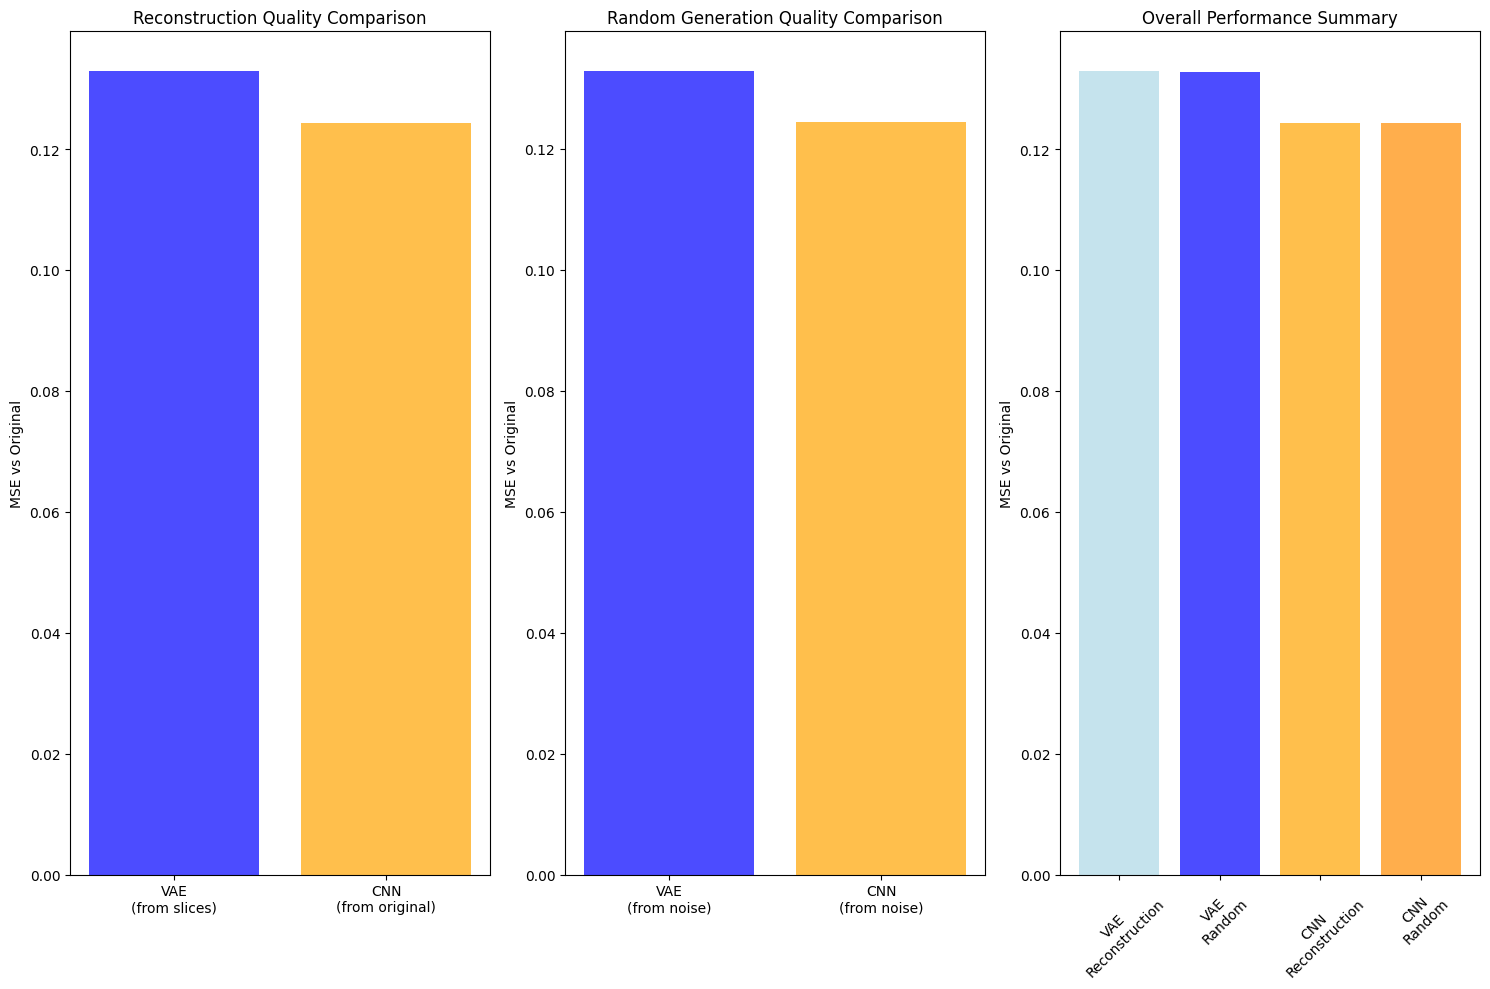


MODEL PERFORMANCE COMPARISON - VAE vs CNN
✓ Better Reconstruction: CNN
  CNN original → original: 0.1244
  VAE slices → original: 0.1328
✓ Better Random Generation: CNN
  CNN noise: 0.1244
  VAE noise: 0.1328

📊 Model Similarity Analysis:
  Random generation similarity: 0.0191
  → Random generation methods produce similar results

🎯 Recommendation:
  Use CNN for both reconstruction and random generation


In [175]:
# Comparative Analysis - VAE vs CNN Generator Performance
import matplotlib.pyplot as plt

# Calculate key metrics for comparison
# VAE metrics
mse_vae_noise_vs_orig = np.mean(residuals_1_vae_noise_vs_original**2)
mse_vae_slices_vs_orig = np.mean(residuals_2_vae_slices_vs_original**2)

# CNN metrics
mse_cnn_vs_orig = np.mean(residuals_4_cnn_vs_original**2)
mse_cnn_noise_vs_orig = np.mean(residuals_5_cnn_noise_vs_original**2)

# Cross-model metrics
mse_vae_noise_vs_cnn_noise = np.mean(residuals_6_vae_noise_vs_cnn_noise**2)

# Create comprehensive comparison plots
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# 1. Reconstruction Quality Comparison
reconstruction_categories = ["VAE\n(from slices)", "CNN\n(from original)"]
reconstruction_mse = [mse_vae_slices_vs_orig, mse_cnn_vs_orig]
axes[0].bar(reconstruction_categories, reconstruction_mse, color=["blue", "orange"], alpha=0.7)
axes[0].set_ylabel("MSE vs Original")
axes[0].set_title("Reconstruction Quality Comparison")

# 2. Random Generation Quality Comparison
random_categories = ["VAE\n(from noise)", "CNN\n(from noise)"]
random_mse = [mse_vae_noise_vs_orig, mse_cnn_noise_vs_orig]
axes[1].bar(random_categories, random_mse, color=["blue", "orange"], alpha=0.7)
axes[1].set_ylabel("MSE vs Original")
axes[1].set_title("Random Generation Quality Comparison")

# 4. Overall Performance Summary
methods = ["VAE\nReconstruction", "VAE\nRandom", "CNN\nReconstruction", "CNN\nRandom"]
performance = [mse_vae_slices_vs_orig, mse_vae_noise_vs_orig, mse_cnn_vs_orig, mse_cnn_noise_vs_orig]
colors = ["lightblue", "blue", "orange", "darkorange"]
axes[2].bar(methods, performance, color=colors, alpha=0.7)
axes[2].set_ylabel("MSE vs Original")
axes[2].set_title("Overall Performance Summary")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Performance insights
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON - VAE vs CNN")
print("="*70)

# Reconstruction comparison
if mse_vae_slices_vs_orig < mse_cnn_vs_orig:
    better_reconstruction = "VAE"
    print(f"✓ Better Reconstruction: {better_reconstruction}")
    print(f"  VAE slices → original: {mse_vae_slices_vs_orig:.4f}")
    print(f"  CNN original → original: {mse_cnn_vs_orig:.4f}")
else:
    better_reconstruction = "CNN"
    print(f"✓ Better Reconstruction: {better_reconstruction}")
    print(f"  CNN original → original: {mse_cnn_vs_orig:.4f}")
    print(f"  VAE slices → original: {mse_vae_slices_vs_orig:.4f}")

# Random generation comparison
if mse_vae_noise_vs_orig < mse_cnn_noise_vs_orig:
    better_random = "VAE"
    print(f"✓ Better Random Generation: {better_random}")
    print(f"  VAE noise: {mse_vae_noise_vs_orig:.4f}")
    print(f"  CNN noise: {mse_cnn_noise_vs_orig:.4f}")
else:
    better_random = "CNN"
    print(f"✓ Better Random Generation: {better_random}")
    print(f"  CNN noise: {mse_cnn_noise_vs_orig:.4f}")
    print(f"  VAE noise: {mse_vae_noise_vs_orig:.4f}")

# Similarity analysis
print(f"\n📊 Model Similarity Analysis:")
print(f"  Random generation similarity: {mse_vae_noise_vs_cnn_noise:.4f}")


if mse_vae_noise_vs_cnn_noise < 0.1:  # Threshold can be adjusted
    print("  → Random generation methods produce similar results")
else:
    print("  → Random generation methods produce different results")

# Overall recommendation
print(f"\n🎯 Recommendation:")
if better_reconstruction == better_random:
    print(f"  Use {better_reconstruction} for both reconstruction and random generation")
else:
    print(f"  Use {better_reconstruction} for reconstruction, {better_random} for random generation")

print("="*70)